In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys, os
sys.path.insert(0,'/content/drive/My Drive/')

In [8]:
!unzip /content/drive/MyDrive/imdb_data/aclImdb.zip

Archive:  /content/drive/MyDrive/imdb_data/aclImdb.zip
replace __MACOSX/._aclImdb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
%matplotlib inline

## Install some stuff you likely don't have
!pip3 -q install --upgrade pip
!pip3 -q install pandas_path
!pip3 -q install fasttext
!pip3 -q install umap-learn[plot]
!pip3 -q install ipywidgets --user

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm

import os

from PIL import Image
import umap
import umap.plot

In [2]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
import re
   
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [4]:
def path_to_dataframe(path):
  path1 = path+'neg/'
  all_files = os.listdir(path1)
  all_files.sort(key=lambda x:int(x[:-4]))
  dictionary_list = []
  for file in all_files:
    with open(os.path.join(path1, file),'r',encoding="utf8") as f:
      text = preprocess_text(f.read())
      dictionary_list.append({'text':text, 'label':0})
  path2 = path+'pos/'
  all_files = os.listdir(path2)
  all_files.sort(key=lambda x:int(x[:-4]))
  for file in all_files:
    with open(os.path.join(path2, file),'r',encoding="utf8") as f:
      text = preprocess_text(f.read())
      dictionary_list.append({'text':text, 'label':1})
  random.shuffle(dictionary_list)
  df = pd.DataFrame.from_dict(dictionary_list)
  return df 

In [5]:
train_path = '/content/aclImdb/train/'
test_path = '/content/aclImdb/test/'

original_set = path_to_dataframe(train_path)
test_set = path_to_dataframe(test_path)

print(original_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'imdb labels')

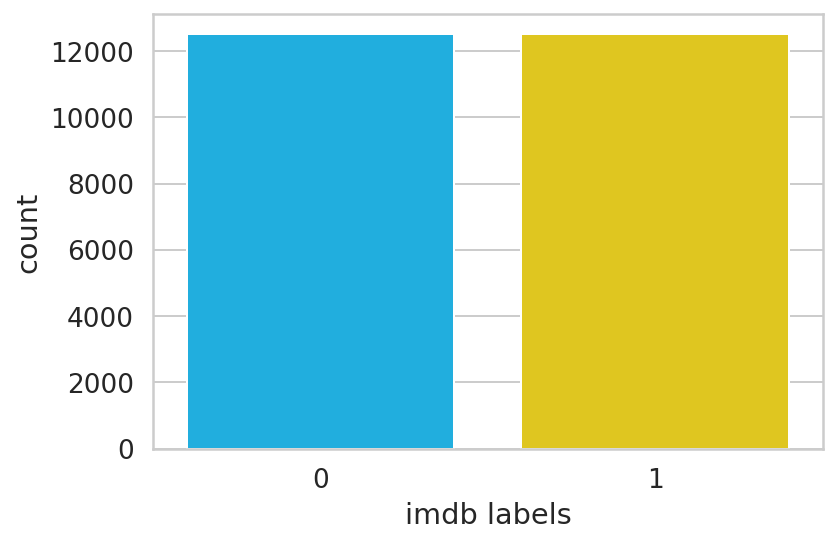

In [7]:
sns.countplot(original_set.label)
plt.xlabel('imdb labels')

In [8]:
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
preprocessed_train_x, y_train = original_set.text[:15000], original_set.label.array[:15000]
preprocessed_test_x, y_test = test_set.text, test_set.label.array

In [10]:
train_piles = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(preprocessed_train_x)):
    # Remove all the special characters
    train_pile = re.sub(r'\W', ' ', str(preprocessed_train_x[sen]))
    
    # remove all single characters
    train_pile = re.sub(r'\s+[a-zA-Z]\s+', ' ', train_pile)
    
    # Remove single characters from the start
    train_pile = re.sub(r'\^[a-zA-Z]\s+', ' ', train_pile) 
    
    # Substituting multiple spaces with single space
    train_pile = re.sub(r'\s+', ' ', train_pile, flags=re.I)
    
    # Removing prefixed 'b'
    train_pile = re.sub(r'^b\s+', '', train_pile)
    
    # Converting to Lowercase
    train_pile = train_pile.lower()
    
    # Lemmatization
    train_pile = train_pile.split()

    train_pile = [stemmer.lemmatize(word) for word in train_pile]
    train_pile = ' '.join(train_pile)
    
    train_piles.append(train_pile)


In [21]:
print(train_piles[2])

it should be against the law not to experience this extremely funny stand up show with eddie murphy have never seen anything like it murphy go on for almost minute about dick pussy tit and insaults so many famous people including his own family among the people who get it by murphy are elvis mr michael jackson stevie wonder mick jagger luther vandross and james brown have seriously never laughed so hard of anything my entire life mean when person doesn know who mr is but still laugh so hard of murphy a mr there something about it at the time saw the show couldn remember who mr wa but still laughed now know who he is and that just make it so much more funny because that what eddie do he can make those impression so good that it don matter who the hell he trying to do it still hilarious and on top of that we learn that murphy actually is very good singer please watch it


In [11]:
test_piles = []

for sen in range(0, len(preprocessed_test_x)):
    # Remove all the special characters
    test_pile = re.sub(r'\W', ' ', str(preprocessed_test_x[sen]))
    
    # remove all single characters
    test_pile = re.sub(r'\s+[a-zA-Z]\s+', ' ', test_pile)
    
    # Remove single characters from the start
    test_pile = re.sub(r'\^[a-zA-Z]\s+', ' ', test_pile) 
    
    # Substituting multiple spaces with single space
    test_pile = re.sub(r'\s+', ' ', test_pile, flags=re.I)
    
    # Removing prefixed 'b'
    test_pile = re.sub(r'^b\s+', '', test_pile)
    
    # Converting to Lowercase
    test_pile = test_pile.lower()
    
    # Lemmatization
    test_pile = test_pile.split()

    test_pile = [stemmer.lemmatize(word) for word in test_pile]
    test_pile = ' '.join(test_pile)
    
    test_piles.append(test_pile)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
x_train = vectorizer.fit_transform(train_piles).toarray()
x_test = vectorizer.fit_transform(test_piles).toarray()

In [45]:
print(x_train[100])

[1 0 0 ... 0 0 0]


In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
x_train = tfidfconverter.fit_transform(x_train).toarray()
x_test = tfidfconverter.fit_transform(x_test).toarray()

In [47]:
print(x_train[100])

[0.0815068 0.        0.        ... 0.        0.        0.       ]


In [48]:
print(y_train)

<PandasArray>
[0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
 ...
 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]
Length: 15000, dtype: int64


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [64]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42, n_jobs=-1)
rf_model = rf.fit(x_train,y_train)

In [65]:
test_predictions = rf_model.predict(x_test)
print(test_predictions)
print(accuracy_score(y_test,test_predictions))

[0 1 1 ... 0 1 1]
0.561


In [66]:
predictions_df = pd.DataFrame()
predictions_df['y_pred'] = test_predictions
predictions_df['y_truth'] = test_set['label']
predictions_df['y_pred'] = predictions_df['y_pred'].astype(int)

predictions_df.head()

,y_pred,y_truth
0,0,0
1,1,1
2,1,1
3,1,0
4,1,1


In [67]:
predictions_df.to_csv('predictions_rf.csv')

In [68]:
from google.colab import files
files.download('/content/predictions_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
max_depths = [5, 300, 500, 700, 1000, 2000]
depth_accuracy = []

for depth in max_depths:
  rf = RandomForestClassifier(n_estimators=1000,max_depth=depth,n_jobs=-1)
  rf_model = rf.fit(x_train,y_train)
  test_predictions = rf_model.predict(x_test)
  depth_accuracy.append(accuracy_score(y_test,test_predictions))


In [76]:
estimators_array = [100, 300, 400, 800, 1000, 200, 3000]
estimator_accuracy = []

for n in estimators_array:
  rf = RandomForestClassifier(n_estimators=n,max_depth=None,n_jobs=-1)
  rf_model = rf.fit(x_train,y_train)
  test_predictions = rf_model.predict(x_test)
  estimator_accuracy.append(accuracy_score(y_test,test_predictions))

In [77]:
print(depth_accuracy)
print(estimator_accuracy)

[0.52016, 0.56012, 0.5576, 0.56032, 0.5616, 0.55844]
[0.55608, 0.56048, 0.56168, 0.55768, 0.56092, 0.559, 0.56012]


Text(0.5, 0, 'Number of trees')

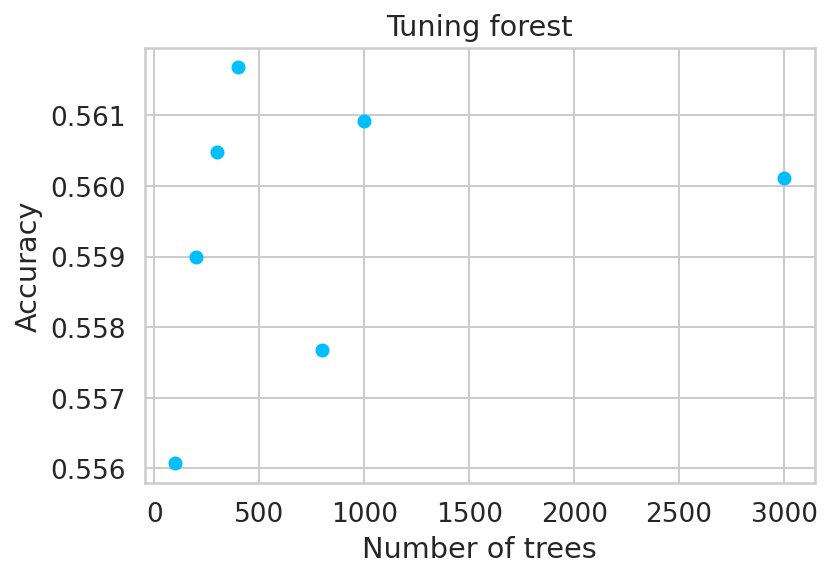

In [83]:
plt.scatter(estimators_array, estimator_accuracy)
plt.title('Tuning forest')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')

Text(0.5, 0, 'Depth')

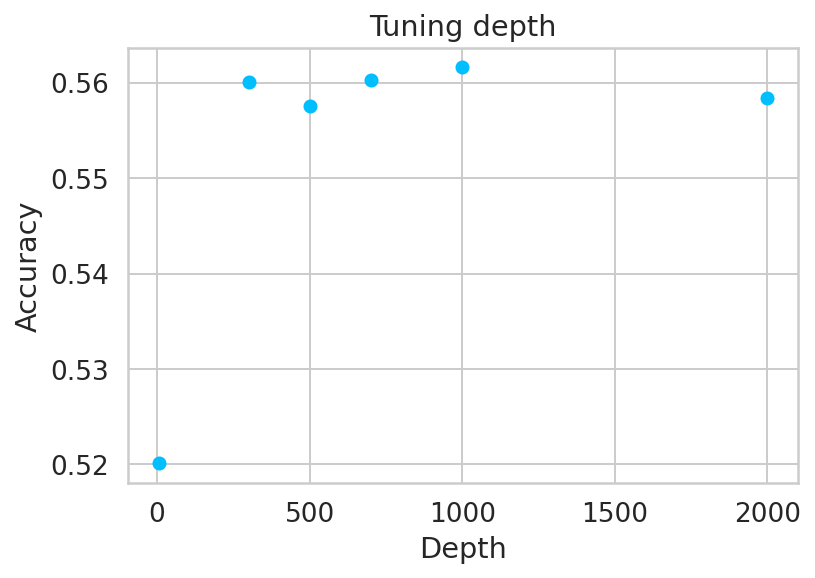

In [79]:
plt.scatter(max_depths, depth_accuracy)
plt.title('Tuning depth')
plt.ylabel('Accuracy')
plt.xlabel('Depth')

In [80]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [81]:
!cp "/content/drive/MyDrive/Colab Notebooks/ml_imdb_random_forest.ipynb" ./ 
!jupyter nbconvert --to PDF "ml_imdb_random_forest.ipynb"

[NbConvertApp] Converting notebook ml_imdb_random_forest.ipynb to PDF
[NbConvertApp] Support files will be in ml_imdb_random_forest_files/
[NbConvertApp] Making directory ./ml_imdb_random_forest_files
[NbConvertApp] Making directory ./ml_imdb_random_forest_files
[NbConvertApp] Making directory ./ml_imdb_random_forest_files
[NbConvertApp] Writing 76905 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 140939 bytes to ml_imdb_random_forest.pdf


In [82]:
files.download('/content/ml_imdb_random_forest.ipynb')
files.download('/content/ml_imdb_random_forest.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Statement of Colaboration:
Tokenization and Vectorizing techniques were taken from [this link](https://stackabuse.com/text-classification-with-python-and-scikit-learn/).